# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = '/content/drive/MyDrive/npr/'
LPRNET_DIR = BASE_DIR + 'LPRNET/'

# Imports

In [ ]:
import itertools
import math
import os
import random
import sys

import cv2
import numpy as np

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [ ]:
from google.colab.patches import cv2_imshow

# Variables

In [ ]:
#COLORS OF PLATES
COLOR_PROBABILITIES = [0.65, 0.25, 0.10]
COLOR_NAMES = ["blanco","naranja","amarillo"]
PLATES_COLORS = [(255,255,255), (12,88,241), (36,167,241)]
COLOR_ID = 0

In [ ]:
FONT_DIR = LPRNET_DIR + "fonts"
FONT_HEIGHT = 32

In [ ]:
PREFIX = ["ගුවන්","යුහ","නාහ"]

In [ ]:
PLATES_COLORS = [(255,255,255)]

In [ ]:
DIGITS = "0123456789"
LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
SINHALA = "ගුවන්යුහනාහ"
CHARS = SINHALA + DIGITS
CHARS = CHARS + " "

In [ ]:
OUTPUT_SHAPE = (24, 94)

In [ ]:
im_codes_acumulate = []

In [ ]:
PLATE_MARGINS = [
    {
        "h_padding" : 0.2,
        "top_padding" : 0.2,
        "bottom_padding" : 0.62,
        "spacing" : 0.005,
        "extra_spacing": [0.2, 0.4],
        "min_scale": 0.38,
        "max_scale": 0.45
        },
    {
        "h_padding" : 0.1,
        "top_padding" : 0.005,
        "bottom_padding" : 0.42,
        "spacing" : 0.005,
        "extra_spacing": [0.2, 0.08],
        "min_scale": 0.5,
        "max_scale": 0.53
        }]

# Helpers

In [ ]:
#Function that returns a char with a its respective img RGB using a font
def make_char_ims(font_path, output_height, color):
    font_size = output_height * 4

    font = ImageFont.truetype(font_path, font_size)

    height = max(font.getsize(c)[1] for c in CHARS)

    for c in CHARS:
        width = font.getsize(c)[0]
        im = Image.new("RGB", (width, height), color)

        draw = ImageDraw.Draw(im)
        draw.text((0, 0), c, (0, 0, 0), font=font)
        scale = float(output_height) / height
        im = im.resize((int(width * scale), output_height), Image.ANTIALIAS)
        yield c, np.array(im).astype(np.uint8)

In [ ]:
#Function that generates de code of plate using a prefined format
def generate_code():
    code = ""
    code = "{}{}{}{}{}".format(
                random.choice(PREFIX),
                random.choice(DIGITS),
                random.choice(DIGITS),
                random.choice(DIGITS),
                random.choice(DIGITS))

    if not (code in im_codes_acumulate):
        im_codes_acumulate.append(code)
        return code
    else:
        return generate_code()

In [ ]:
def rounded_rect(shape, radius):
    out = np.ones(shape,dtype=np.uint8)
    out[:radius, :radius] = 0.0
    out[-radius:, :radius] = 0.0
    out[:radius, -radius:] = 0.0
    out[-radius:, -radius:] = 0.0

    cv2.circle(out, (radius, radius), radius, 1.0, -1)
    cv2.circle(out, (radius, shape[0] - radius), radius, 1.0, -1)
    cv2.circle(out, (shape[1] - radius, radius), radius, 1.0, -1)
    cv2.circle(out, (shape[1] - radius, shape[0] - radius), radius, 1.0, -1)

    # Change the out in 3 channels
    out_3c = np.zeros( ( np.array(out).shape[0], np.array(out).shape[1], 3 ),dtype=np.uint8)
    out_3c[:,:,0] = out * 255
    out_3c[:,:,1] = out * 255
    out_3c[:,:,2] = out * 255

    return out_3c

def overlap_mask(img1,img2, mask_overlay=None):

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    mask = None
    if (mask_overlay is None):
        _ , mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    else:
        mask_overlay = cv2.cvtColor(mask_overlay,cv2.COLOR_BGR2GRAY)
        _ , mask = cv2.threshold(mask_overlay, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    img1[0:rows, 0:cols ] = dst

    return img1

In [ ]:
def generate_plate(font_height, font_char_ims):

    #Select the char of an specific color and the color
    random_idx = np.random.choice(len(PLATES_COLORS),p=COLOR_PROBABILITIES)
    char_ims = font_char_ims[random_idx]
    plate_color = PLATES_COLORS[random_idx]
    print("COLOR: {}".format(COLOR_NAMES[random_idx]))

    #Select the info parameter according to the type of plate
    plate_info = PLATE_MARGINS[0]

    #Define some spacing in the vertical and horizontal way
    h_padding = plate_info["h_padding"] * font_height
    top_padding = plate_info["top_padding"] * font_height
    bottom_padding = plate_info["bottom_padding"] * font_height

    #Define the spacing between characters
    spacing = font_height * plate_info["spacing"]

    #Definig the radious of the rounded rect of the plate
    radius = 1 + int(font_height * 0.1)

    #Generate a random code to a plate
    code = generate_code()

    #Define the text_widh considering the space of each letter and
    #some spacing between them
    text_width = sum(char_ims[c].shape[1] for c in code)
    text_width += (len(code) - 1) * spacing

    #Here we use extra spacing to follow the format 1 and 2 of chilean license plates
    #The extra spacing is added each two characters
    out_shape = (int(font_height + top_padding + bottom_padding) ,
                 int(text_width + (h_padding * 2) + plate_info["extra_spacing"][0] * font_height + plate_info["extra_spacing"][1] * font_height))

    #Generate the matrix where we will place the character of the plate
    # text_mask = np.zeros(out_shape)

    text_mask = np.zeros((out_shape[0],out_shape[1],3),dtype=np.uint8)
    text_mask[:]=plate_color

    #Iterate for the characters of code adding some padding, spacing a extra spacing
    #between character.
    x = h_padding
    y = top_padding

    i = 0
    for idx, c in enumerate(code,1):
        char_im = char_ims[c]
        ix, iy = int(x), int(y)
        text_mask[iy:iy + char_im.shape[0], ix:ix + char_im.shape[1]] = char_im
        x += char_im.shape[1] + spacing
        #if (idx % 2 == 0 and idx < len(code)):
        #    x += plate_info["extra_spacing"][i] * font_height
        #    i += 1

    # Png image mask
    png_mask = cv2.imread(LPRNET_DIR + 'mask/mask_type1.png')

    resize_mask = cv2.resize(png_mask, (text_mask.shape[1],text_mask.shape[0]))

    plate_with_mask = overlap_mask(text_mask,resize_mask)

    # cv2.imshow("out",plate_with_mask)
    # cv2.waitKey(0)

    return plate_with_mask, rounded_rect(out_shape, radius), code.replace(" ", "")

In [ ]:
def load_fonts(folder_path,font):
    '''
    Creates a dictionary of the given font

    :return:
        Dictionary: key - character, value - the matrix of character
    '''
    font_char_ims = []

    for color in PLATES_COLORS:
        font_char_ims.append(dict(make_char_ims(os.path.join(folder_path,
                                                font),
                                                FONT_HEIGHT,color)))
    return font_char_ims

In [ ]:
def generate_im(font_char_ims):
    '''
    Generate images with a background and a plate given

    font_char_ims: the dict of the char with a especific font
    num_bg_image: the total number of images generated
    '''
    #Generate a background given the total number of background


    #Generate a plate and plate_mask given a height and the dictionary of fonts
    plate, plate_mask, code = generate_plate(FONT_HEIGHT, font_char_ims)

    cv2_imshow(plate)
    cv2.waitKey(0)



    #Resize the image with the final outputs
    out = cv2.resize(plate, (OUTPUT_SHAPE[1], OUTPUT_SHAPE[0]))

    return out, code


In [ ]:
def generate_ims():
    """
    Generate number plate images.

    :return:
        Iterable of number plate images.

    """

    #get the dictionary of fonts where key is the character and value are the matrix of that character (or image)
    font = "iskoola.ttf"
    font_char_ims = load_fonts(FONT_DIR,font)

    #takes the total number of background in the folder PARAMS.dataset
    while True:
      yield generate_im(font_char_ims)
        #generate an image given the dictionaty of fonts and the total number of background




# Gen

In [ ]:
def gen():

    #create a iterator with coroutine that five the total number of images
    im_gen = itertools.islice(generate_ims(), 10)

    #iterate through the iterator display the name and store in the folder test
    for img_idx, (im, c) in enumerate(im_gen,1):
        fname = LPRNET_DIR + "gen_plates/{:012d}-gen{}_{}.jpg".format(img_idx,1,c)
        print(fname)
        cv2.imwrite(fname, im)

# Test

COLOR: naranja


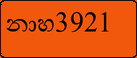

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000001-gen1_නාහ3921.jpg
COLOR: blanco


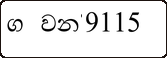

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000002-gen1_ගුවන්9115.jpg
COLOR: blanco


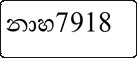

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000003-gen1_නාහ7918.jpg
COLOR: blanco


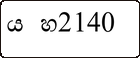

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000004-gen1_යුහ2140.jpg
COLOR: blanco


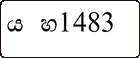

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000005-gen1_යුහ1483.jpg
COLOR: blanco


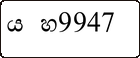

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000006-gen1_යුහ9947.jpg
COLOR: naranja


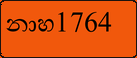

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000007-gen1_නාහ1764.jpg
COLOR: naranja


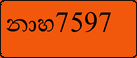

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000008-gen1_නාහ7597.jpg
COLOR: naranja


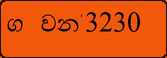

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000009-gen1_ගුවන්3230.jpg
COLOR: blanco


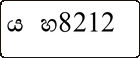

/content/drive/MyDrive/npr/LPRNET/gen_plates/000000000010-gen1_යුහ8212.jpg


In [ ]:
gen()